# TD - Recherche de minimum et descente de gradient
Dans ce TD, nous nous interesons aux méthodes pour rechercher le minimum d'une fonction. nous allons étudier deux méthodes :
- [**Méthode du nombre d'or**](https://fr.wikipedia.org/wiki/M%C3%A9thode_du_nombre_d%27or) (ou [`Golden-section search`](https://en.wikipedia.org/wiki/Golden-section_search) en anglais) pour rechercher le minimum d'une fonction mono-variable
- [**Algorithme du gradient**](https://fr.wikipedia.org/wiki/Algorithme_du_gradient) (ou [`Gradient descent`](https://en.wikipedia.org/wiki/Gradient_descent) en anglais) pour rechercher le minimum d'une fonction mutli-variables

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib notebook

In [11]:
def plot_gradient(f, x_opt, x_hist):
    """
    Trace en 2D la fonction f (de R dans R) et dessine l'évolution de x au cours des itérations de la décsente de gradiant
    
    Parameters
        ----------
        f : callable
            Fonction optimisé (de R dans R)
        x_opt : float
            valeur de x pour laquelle la fonction f est minimul
        x_hist : list de float
            Liste de l'historique des valeurs de x obtenu lors de l'optimisation
    """
    x_hist = np.array(x_hist)
    x_d = np.max(np.abs(x_hist-x_opt))
    x_min = x_opt - x_d*1.1
    x_max = x_opt + x_d*1.1
    
    x = np.arange(x_min, x_max, 0.1)
    y = f(x)
    plt.figure()
    plt.plot(x,y)
    f = np.vectorize(f)
    plt.plot(x_hist, f(x_hist),marker = 'o', markeredgecolor = 'red', markerfacecolor = 'red');
    

def plot3d_gradient(f, x_opt, x_hist):
    """
    Trace en 3D la fonction f (de R^2 dans R) et dessine l'évolution de x au cours des itérations de la décsente de gradiant
    
    Parameters
        ----------
        f : callable
            Fonction optimisé (de R^2 dans R)
        x_opt : numpy array (shape = (2, ))
            valeur de x pour laquelle la fonction f est minimul
        x_hist : list de numpy array (shape = (2, ))
            Liste de l'historique des valeurs de x obtenu lors de l'optimisation
    """
    x_hist = np.vstack(x_hist)
    delta = np.max(np.abs(x_hist-x_opt))
    x_min = x_opt[0] - delta*1.1
    x_max = x_opt[0] + delta*1.1
    y_min = x_opt[1] - delta*1.1
    y_max = x_opt[1] + delta*1.1
    fig = plt.figure()
    ax = Axes3D(fig)
    xs = np.linspace(x_min, x_max, 50)
    ys = np.linspace(y_min, y_max, 50)
    X, Y = np.meshgrid(xs, ys)
    
    P = np.vstack((X.reshape(-1),Y.reshape(-1))).T
    f = np.vectorize(f, signature='(n)->()')
    Z = f(P).reshape(X.shape)
    
    ax.plot_surface(X, Y, Z, rstride=2, cstride=1,linewidth=1, alpha=0.5,antialiased=True)
    ax.contour(X, Y, Z)
    ax.plot(x_hist[:,0], x_hist[:,1], f(x_hist),marker = 'o', markeredgecolor = 'red', markerfacecolor = 'red')
    ax.set_xlabel('X',fontsize=18)
    ax.set_ylabel('Y',fontsize=18)

## Avant toute chose
pour ce TD, nous cherchons le minimum de fonction polynomiale d'ordre 2 [convexe](https://fr.wikipedia.org/wiki/Fonction_convexe).

### Rappel

Une fonction polynomiale d'ordre 2 est de la forme :
$$
f(x) = a*x^2 + b*x + c
$$
avec $(a,b,c)\in \mathbb{R}^3$.

Un polynome d'ordre 2 est convexe quand :
$$
\frac{d^2 f}{d x^2}(x) > 0
$$
**Question** Quelles sont les contraintes sur $a$, $b$ et $c$ pour que f(x) soit convexe ?

Les contraintes sont :
- $a$ est réel positif
- $b$ est réel
- $c$ est réel

Un polynome d'ordre 2 convexe est minimum quand :
$$
\frac{d f}{d x}(x) = 0
$$
**Question** Pour quelle valeur $x_{\text{opt}}$, $f(x)$ est t-il minimum ?

$$
x_{\text{opt}} = - \frac b {2a}
$$

### Notre polynome
**À faire** Choisissez des valeurs pour $a$, $b$ et $c$, tel-que f(x) soit convexe et que $x_{\text{min}} \neq 0$.

**Question** Que vaut $x_{\text{opt}}$ ?

$$
a = 2
$$
$$
b = -4
$$
$$
c = 5
$$
$$
x_{\text{opt}} = 1
$$

**À faire** Complétez la fonction `def compute_f(x)` pour qu'elle calcule le polynome avec vos valeurs de $a$, $b$ et $c$.

In [12]:
def compute_f(x):
    a = 2
    b = -4
    c = 5
    return a*x**2+b*x+c

## Méthode du nombre d'or
Le méthode du nombre d'or consiste à rechercher le minimum d'une fonction unimodale (un seul minimum) et mono-variable.
Pout utiliser cette méthode, il est nécessaire de savoir que le minimum de la fonction se situe dans l'intervalle de départ :
$$
x_1 < x_{\text{opt}} < x_3
$$
avec $(x_1, x_3)$ l'intervalle de départ.

Comme $f(x)$ est unimodale entre $x_1$ et $x_3$, nous prenons un point $x_2$ compris entre $x_1$ et $x_3$ tel que nous avons $f(x2) < f(x1)$ et $f(x2) < f(x3)$.

Nous voulons savoir si le minimum est compris dans l'intervalle $(x_1, x_2)$ ou $(x_2, x_3)$.
Pour cela, nous sondons la fonction avec un nouveau point $x_4$.
On peux choisir $x_4$ dans l'intervalle $(x_1, x_2)$ ou $(x_2, x_3)$, mais il est plus intéressant de prendre $x_4$ dans l'intervalle le plus grand.
Par exemple, nous dirons que l'intervalle le plus grand est $(x_2, x_3)$ donc $x_2 < x_4 < x_3$.

Selon la valeur de $f(x_4)$, nous avons 2 cas possibles :
- $f(x_4) > f(x_2)$, nous savons alors que le minimum se trouve dans l'intervalle $(x_1, x_4)$
- $f(x_4) < f(x_2)$, nous savons alors que le minimum se trouve dans l'intervalle $(x_2, x_3)$

Il est alors possible de recommencer sur le nouvel intervalle de manière itérative.

La **méthode du nombre d'or** est similaire à la [recherche par dichotomique](https://fr.wikipedia.org/wiki/Recherche_dichotomique), mais le choix des points utilise le nombre d'or plutôt que le nombre 2.

Plus precisement, pour l'intervalle $(x_1, x_3)$, alors les sondes $x_2$ et $x_4$ sont :
$$
x_2 = x_3 - \frac{x_3-x_1}{\varphi}
$$
$$
x_4 = x_1 + \frac{x_3-x_1}{\varphi}
$$

avec $\varphi = \frac{1+\sqrt(5)}{2}$

Pour déterminer la convergence de la méthode, nous vérifions si :
$$
|x_2-x_4| < \epsilon
$$
avec $\epsilon$ petit.

**À faire** Complétez la fonction `mno(f, x_1, x_3, tol)` qui recherche le minimum de la fonction $f$ entre $x_1$ et $x_3$ avec la méthode du nombre d'or.

In [13]:
def mno(f, x_1, x_3, epsilon):
    nombre_dor = (math.sqrt(5) + 1) / 2
    
    x_2 = x_3 - (x_3 - x_1) / nombre_dor
    x_4 = x_1 + (x_3 - x_1) / nombre_dor 
    while abs(x_2 - x_4) > epsilon:
        if f(x_2) < f(x_4):
            x_3 = x_4
        else:
            x_1 = x_2

        x_2 = x_3 - (x_3 - x_1) / nombre_dor
        x_4 = x_1 + (x_3 - x_1) / nombre_dor

    x_opt = (x_3 + x_1) / 2
    return x_opt

**À faire** Testez la méthode du nombre d'or, sur votre polynome `compute_f(x)`.

In [14]:
print('x_opt =', mno(compute_f, -100, 100, 1e-16))

x_opt = 1.000000010536712


## Algorithme du gradient
L'algorithme du gradient (ou de descente de gradient) est une algorithme itératif pour trouver le minimum d'une fonction.

Pour utiliser l'algorithme, nous devons lui donner uniquement un point de départ $x_0$.
Pour trouver le minimum de la fonction, l'algorithme met à jour à chaque itération la position du point $x_t$ en le déplaçant dans la direction du gradient:
$$
x_{t+1} = x_t - \mu_t \frac{d f}{d x} (x_t)
$$
avec $\mu_t$ le "pas" qui définit de combien nous avançons dans la direction du gradient.

Nous avons besoin du gradient de la fonction $f(x)$ dont nous cherchons le minimum.

**À faire** Complétez la fonction `def compute_df(x)` pour qu'elle calcule le gradient du polynome avec vos valeurs de $a$, $b$ et $c$.

In [15]:
def compute_df(x):
    a = 2
    b = -4
    return 2*a*x+b

### Méthode de gradient à pas fixe
Dans un premier temps, nous considerons le pas fixe : $\mu_t = \text{constant}$.

Nous voulons étudier l'influence du pas sur la convergence de l'algorithme.

**À faire** Complétez la fonction `def algo_gradient1(f,df,mu,x_0,n)` qui calcul `n` itérations de la méthode du gradient en partant de `x_0` et avec un pas fixe de `mu`.
La fonction doit retourner une liste contenant l'historique de l'évolution de $x$ au cours des itération.

In [16]:
def algo_gradient1(f,df,mu,x_0,n):
    x = x_0
    x_hist = [x_0, ]
    fx_hist = [f(x_0), ]
    
    for i in range(n):
        x = x - mu * df(x)
        x_hist.append(x)
        fx_hist.append(f(x))
        
    return x_hist

**À faire** Choisirez un point de départ et utilisez la méthode du gradient à pas fixe pour différente valeurs du pas (0.0001, 0.1, 0.4, 0.5, 0.6).
Utilisez la fonction `plot_gradient` (defini en haut du notebook) pour afficher les différents cas.

<IPython.core.display.Javascript object>


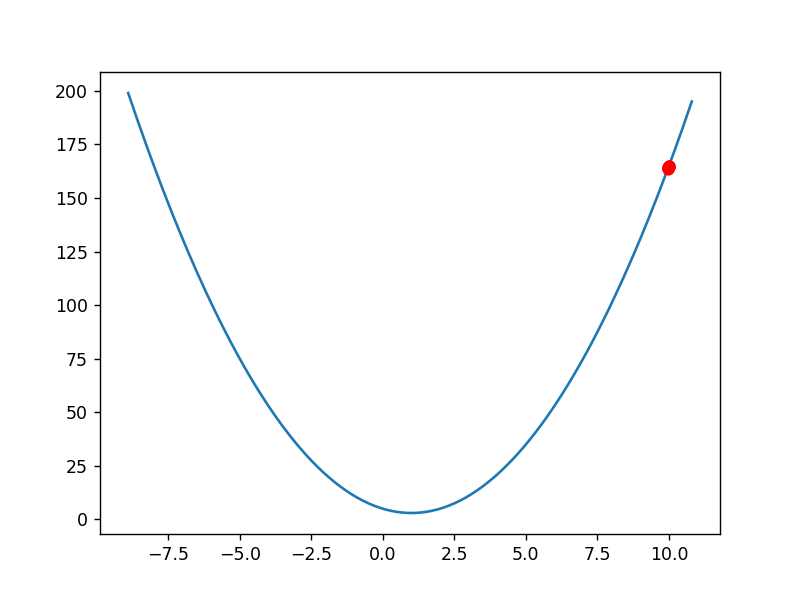

<IPython.core.display.Javascript object>


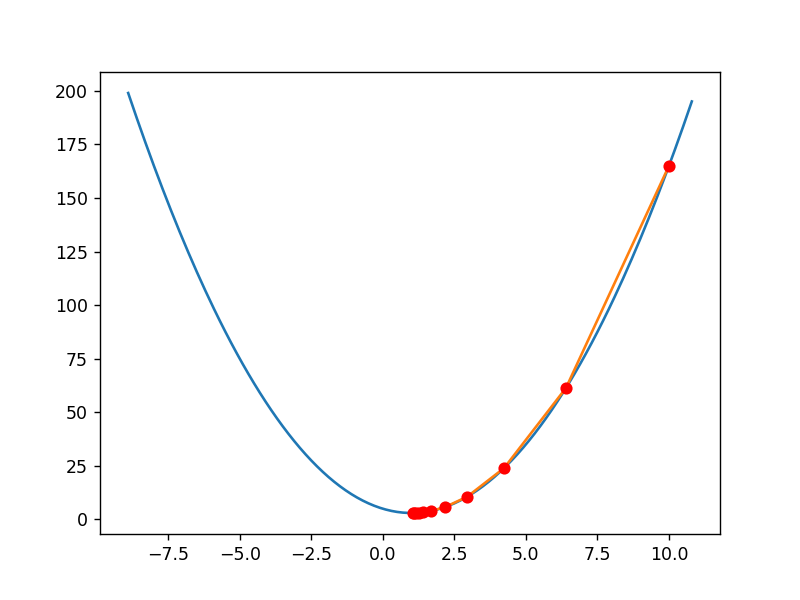

<IPython.core.display.Javascript object>


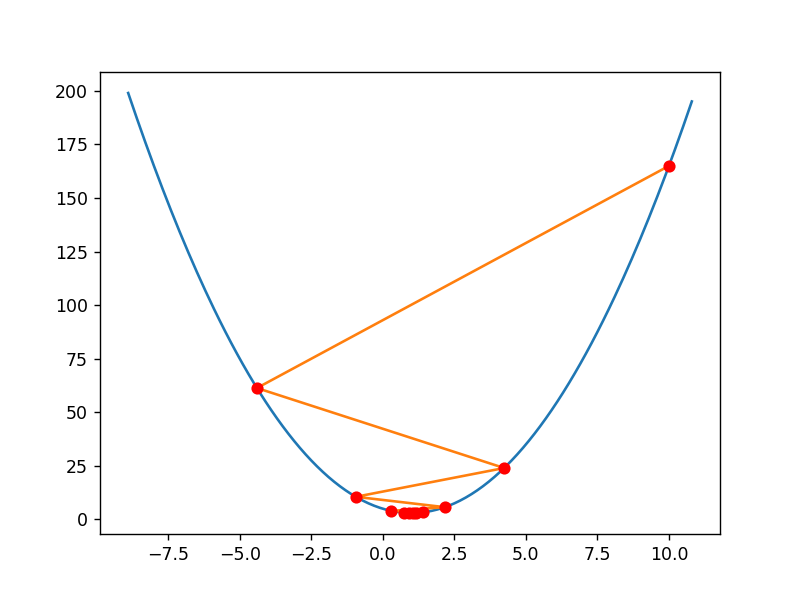

<IPython.core.display.Javascript object>


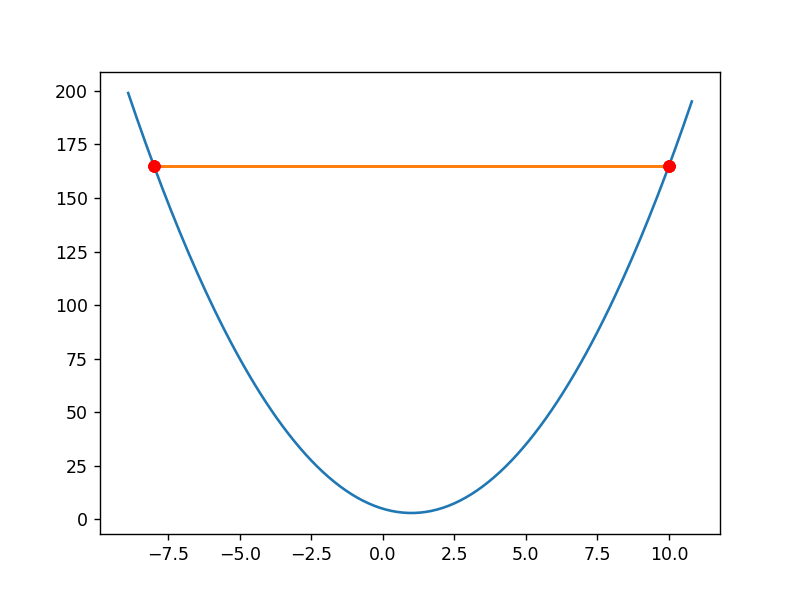

<IPython.core.display.Javascript object>


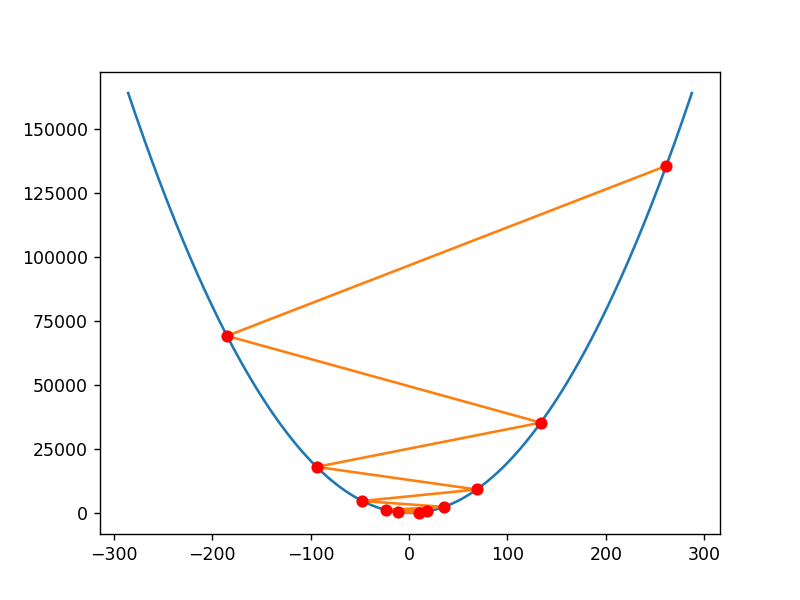

In [17]:
for mu in (0.0001,0.1,0.4,0.5,0.6):
    x_hist = algo_gradient1(compute_f, compute_df, mu, 10.0, 10)
    plot_gradient(compute_f, 1, x_hist)

**Question** Que constatez-vous ?

**Réponse** On constate qu'un gradient trop petit ne converge pas suffisamment et qu'un gradient trop grand diverge.

Dans la méthode du gradient, le nombre d'itérations est inconnu à l'avance. Généralement, on poursuit les itérations jusqu'à atteindre le critère d'arrêt suivant :
$$
\|\nabla f(x_k)\| \leqslant \varepsilon
$$
avec $\nabla f(x_k)$ le gradient de la fonction $f(x)$.
dans le cas mono-variable s'ecrit:
$$
\left| \frac{d f}{d x}(x_k)\right| \leqslant \varepsilon
$$
**À faire** Complétez la fonction `algo_gradient2(f,df,mu,x_0,espilon)` qui recherche le minimum de la fonction $f$ avec la méthode du gradient (n'oubliez pas le cas où l'algorithme diverge).
La fonction doit retourner la valeur de x à l'optimum et une liste contenant l'historique de l'évolution de $x$ au cours des itération.

In [18]:
def algo_gradient2(f,df,mu,x_0,espilon):
    x = x_0
    x_hist = [x, ]
    fx = f(x)
    dfx = df(x)
    # Stop if...
    while(np.fabs(dfx)>espilon):
        x = x - mu*dfx
        x_hist.append(x)
        fx2 = f(x)
        if(fx2 >= fx): # no divergence
            break
        # update
        fx = fx2
        dfx = df(x)
    
    return x, x_hist

**À faire** Testez la méthode du gradient, sur votre polynome compute_f(x) et utilisez la fonction `plot_gradient` (defini en haut du notebook) pour afficher l'évolution de votre déscente de gradient.

x_opt = 1.0000000043310682


<IPython.core.display.Javascript object>


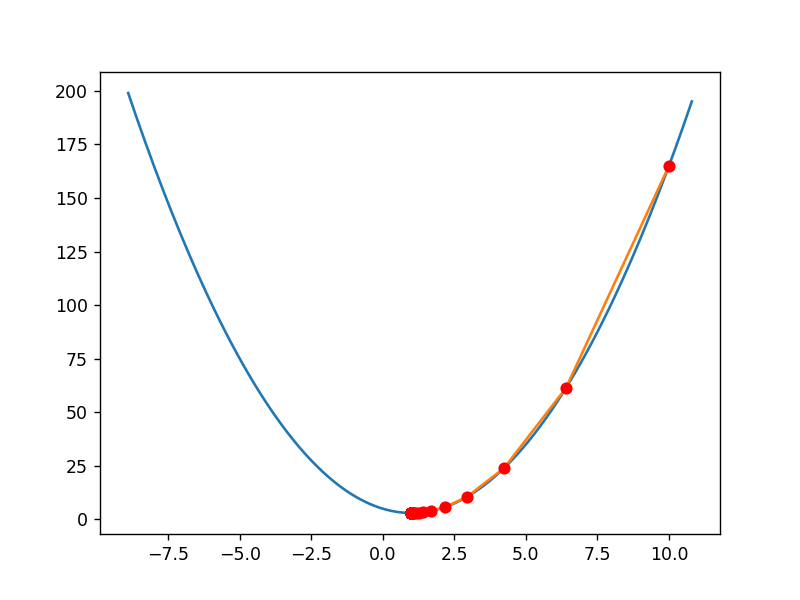

In [19]:
x_opt, x_hist = algo_gradient2(compute_f, compute_df, 0.1, 10.0, 1e-16)
print('x_opt =', x_opt)
plot_gradient(compute_f, x_opt, x_hist)

### Cas multi-variable

Dans le cas multi-variable, 
$$
f\colon \mathbb {R}^D  \to \mathbb {R} \\
$$
la méthode du gradient est exactement la même que pour le cas mono-variable. La mise à jours s'effectue de la manière suivante :
$$
\mathbf{x}_{k+1} = \mathbf{x}_{k} - \mu \times \nabla f(\mathbf{x}_k)
$$
avec $\mathbf{x}_k\in\mathbb{R}^D$ un vecteur de taille D.

Dans la suite, nous utiliserons la fonction quadratique multi-variable suivante :
$$
\begin{aligned}f\colon \mathbb {R}^D & \to \mathbb {R} \\\mathbf{x} & \mapsto \mathbf{x}^\top\mathbf{A}\mathbf{x}+\mathbf{x}^\top\mathbf{b}+c.\end{aligned}
$$
avec 
$$
\mathbf{A} = \begin{bmatrix}
   2 & 1 \\
   2 & 4 
\end{bmatrix} \text{, } \mathbf{b} = \begin{bmatrix}
   1 \\
   2  
\end{bmatrix} \text{ et } c = 2
$$
le gradient de $f(\mathbf{x})$ s'ecrit :
$$
\begin{aligned}\nabla f \colon \mathbb{R}^D & \to \mathbb{R}^D \\\mathbf{x} & \mapsto (\mathbf{A}+\mathbf{A}^\top)\mathbf{x}+\mathbf{b}.\end{aligned}
$$

Le $\mathbf{x}_{\text{opt}}$ est alors:
$$
\mathbf{x}_{\text{opt}} = -\frac{1}{23} \begin{bmatrix} 2\\ 5 \end{bmatrix}
$$

Les fonctions pour calculer la fonction $f(\mathbf{x})$ et son gradient sont les suivantes :

In [20]:
def compute_f2(x):
    A = np.array(((2,1),(2,4)))
    b = np.array((1,2))
    c = 2
    
    return np.dot(np.dot(x.T,A),x) + np.dot(x.T,b) + c

def compute_df2(x):
    A = np.array(((2,1),(2,4)))
    b = np.array((1,2))
    c = 2
    
    return np.dot(A+A.T,x) + b

x_opt = np.array((-2./23,-5./23))

print('compute_f2(x_opt)=', compute_f2(x_opt))
print('compute_df2(x_opt)=', compute_df2(x_opt))

compute_f2(x_opt)= 1.7391304347826086
compute_df2(x_opt)= [0. 0.]


`x` est alors un `np.zeros((2,1))`

**À faire** Complétez la fonction `algo_gradient3(f,df,mu,x_0,espilon, max_iter)` qui recherche le minimum de la fonction $f$ avec la méthode du gradient pour le cas multi-variable (n'oubliez pas le cas où l'algorithme diverge et ajouté un critère d'arrête sur le nombre maximum d'itération ). 
La fonction doit retourner la valeur de x à l''optimum et une liste contenant l'historique de l'évolution de $x$ au cours des itération.
Pour calculer la norme d'une vecteur, vous pouvez utiliser la fonction [numpy.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html).

In [21]:
def algo_gradient3(f,df,mu,x_0,espilon, max_iter):
    x = x_0
    x_hist = [x, ]
    fx = f(x)
    dfx = df(x)
    k = 0
    while(np.linalg.norm(dfx) > espilon and k < max_iter):
        x = x - mu*dfx
        
        x_hist.append(x)

        if(f(x) >= fx):
            break
        fx = f(x)
        dfx = df(x)
        
        k = k + 1

    return x, x_hist

**À faire** Testez la méthode du gradient, sur votre la fonction `compute_f2(x)` et utilisez la fonction `plot3d_gradient` (defini en haut du notebook) pour afficher l'évolution de votre déscente de gradient.

compute_f2(x_0) = 212
compute_df2(x_0) = [-34 -53]
x_opt_2 = [-0.08695654 -0.21739129]
compute_f2(x_opt_2) = 1.7391304347826093
compute_df2(x_opt_2) = [-4.64256300e-08  2.48462433e-08]


<IPython.core.display.Javascript object>


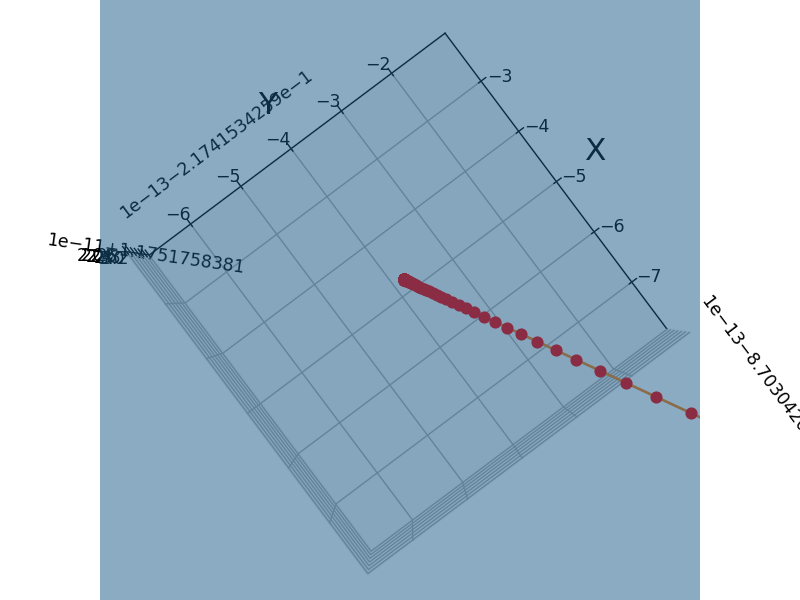

C:\Users\jules\AppData\Local\Temp/ipykernel_18076/699685591.py:47: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [22]:
x_0 = np.array((-5,-5))
print('compute_f2(x_0) =', compute_f2(x_0))
print('compute_df2(x_0) =', compute_df2(x_0))
x_opt_2, x_hist_2 = algo_gradient3(compute_f2, compute_df2, 0.05, x_0, 1e-10, 10000)
print('x_opt_2 =', x_opt_2)
print('compute_f2(x_opt_2) =', compute_f2(x_opt_2))
print('compute_df2(x_opt_2) =', compute_df2(x_opt_2))

plot3d_gradient(compute_f2, x_opt_2, x_hist_2)

**Question** Que constatez-vous ?

**Réponse** ??????????

### Méthode du gradient à pas optimal
La méthode du gradient à pas fixe demande un grand nombre d'itération pour converger et trouver le pas fixe le plus adapté n'est pas trivial.

Pour que la méthode converge plus rapidement et que nous n'ayons plus à choisir le pas, nous pouvons choisir à chaque itération le pas optimal pour la direction du gradient calculée à l'itération.

En effet, une fois que nous avons la direction dans laquelle nous voulons avancer, dans notre cas le gradient $-\nabla f(\mathbf{x}_k)$, la question est alors de combien doit-t'on avancer dans cette direction pour aller le plus bas ?

Cela revient à chercher le minimum de la fonction suivante :
$$
g(\mu_k) = f\left(\mathbf{x}_{k} - \mu_k \times \nabla f(\mathbf{x}_k)\right)
$$
avec $\mu_k > 0$.
Nous voyons que la fonction $g(\mu_k)$ est une fonction mono-variable, il est alors donc possible d'utiliser la méthode du nombre d'or pour trouver son minimum.

**À faire** Complétez la fonction algo_gradient4(f,df,x_0,espilon, max_iter) qui recherche le minimum de la fonction f avec la méthode du gradient pour le cas multi-variable en calculant le pas optimal à chaque itération avec la méthode du nombre d'or (n'oubliez d'ajouté un critère d'arrête sur le nombre maximum d'itération ).
La fonction doit retourner la valeur de x à l''optimum et une liste contenant l'historique de l'évolution de $x$ au cours des itération.

In [ ]:
def algo_gradient4(f,df,x_0,espilon, max_iter):
    
    return x, x_hist

**À faire** Testez la méthode du gradient à pas optimal, sur votre la fonction `compute_f2(x)`

In [ ]:
x_0 = np.array((-5,-5))

**Question** Que constatez-vous ?

## Remarque
Il existe déjà ces méthodes d'optimisation en python ([scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)). 

Nous aurions pu faire comme cela :

In [ ]:
from scipy import optimize
x_0 = np.array((-5,-5))
print(optimize.fmin_cg(compute_f2, x_0, fprime=compute_df2))